# Анализ эффективности, и разработка модели принятия решений 

![jupyter](2022-12-09_12-28-54.png)

### Описание проекта

Требуется провести анализ эффективности системы поддержки принятия решений для согласования медицинских услуг между клиникой и страховой компанией и предложить методику выявления кейсов, которые могут быть отработаны системой без участия бизнес-пользователей (далее Зеленые Кейсы)

**Определение:** Кейс - набор запрашиваемых клиникой медицинских услуг по одному застрахованному с указанием диагнозов и данных по застрахованному

**Определение:** Решение системы по согласованию услуг - отметка TRUE или FALSE, проставляемая системой поддержки принятия решений напротив каждой запрошенной медицинской услуги.
- TRUE - система подтвердила, что данная услуга может быть оказана по страховке с учетом входных данных
- FALSE - система выявила причину, почему данная услуга НЕ может быть оказана по страховке

**Важно:** сейчас все решения системы перепроверяются бизнес-пользователями (сотрудниками страховой компании). Каждое решение системы может быть скорректировано бизнес-пользователем. В данном случае во входных данных проставлена соответствующая отметка

**Определение:** Зеленый кейс - кейс, в котором с большой долей вероятности (более 90%) не будет произведено ни одной корректировки решений по согласованию или отказу, выданных системой поддержки принятия решений

### **Задачи проекта:**

1. Проведение классификации кейсов на Зеленые Кейсы и остальные кейсы (в которых была хотя бы одна корректировка решения системы по согласованию услуг)
2. Предложен алгоритм, который позволяет на основании входных данных (т.е. все данные кроме решения системы по согласованию услуг и отметки о корректировке решения бизнес-пользователем) с высокой степенью вероятности выявить Зеленые Кейсы среди прочих
3. Проведение тестирования алгоритма на имеющихся данных

**Данные используемые для выявления зеленых кейсов**

    1. Данные о запрошенных услугах (в том числе общее количество услуг в кейсе)
    2. Диагнозы, привязанные к кейсу
    3. Пол и возраст застрахованного
    4. Код лечебного учреждения, запросившего согласования

### Описание данных

- **service_id** - уникальный идентификатор строки данных
- **case_id** - уникальный идентификатор номера кейса
- **name** - наименование медицинской услуги
- **tooth_num** - номера зубов
- **count** - количество услуг
- **approve_result** - результат согласования
- **decline_reason** - причина отказа в согласовании
- **mkb** - диагноз по МКБ10
- **rules_worked** - сработавшие правила
- **corrected** - результат согласования скорректирован
- **policy_number** - номер полиса застрахованного
- **sex** - пол застрахованного
- **age** - возраст застрахованного
- **lpu_code** - кодировка поликлиники

In [1]:
#pip install pyxlsb

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

In [3]:
df = pd.read_excel('Данные_СК.xlsb')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73938 entries, 0 to 73937
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   service_id      73938 non-null  int64 
 1   case_id         73938 non-null  int64 
 2   name            73932 non-null  object
 3   tooth_num       983 non-null    object
 4   count           73938 non-null  int64 
 5   approve_result  73938 non-null  bool  
 6   decline_reason  20448 non-null  object
 7   mkb             72189 non-null  object
 8   rules_worked    21303 non-null  object
 9   corrected       73938 non-null  object
 10  policy_number   73938 non-null  object
 11  sex             73938 non-null  object
 12  age             73938 non-null  int64 
 13  lpu_code        73938 non-null  int64 
dtypes: bool(1), int64(5), object(8)
memory usage: 7.4+ MB


In [5]:
df.head()

,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
0,57920,8421,Креатинин,NaN,1,True,NaN,D64.9 Анемия неуточненная,NaN,Нет,Пр6130156,Ж,42,1
1,93309,8421,Билирубин прямой,NaN,1,True,NaN,D64.9 Анемия неуточненная,NaN,Нет,Пр6130156,Ж,42,1
2,99016,8421,"Регистрация ЭКГ, расшифровка, описание и интер...",NaN,1,True,NaN,D64.9 Анемия неуточненная,NaN,Нет,Пр6130156,Ж,42,1
3,42276,8297,Мочевина,NaN,1,True,NaN,N11 Хронический тубулоинтерстициальный нефрит;...,NaN,Нет,Пр5280489,Ж,32,2
4,78884,8297,Биопсия молочной железы,NaN,1,True,NaN,N11 Хронический тубулоинтерстициальный нефрит;...,NaN,Нет,Пр5280489,Ж,32,2


## Предобработка данных

### Проверка "service_id" - уникальный идентификатор строки данных, на дубликаты

In [6]:
df['service_id'].duplicated().sum()

19035

In [7]:
# проверим дубликаты через группировку
df.groupby(['service_id'], as_index=False).agg({'service_id':'count'})['service_id'].value_counts()

1    39840
2    11702
3     2830
4      466
5       52
6       11
7        2
Name: service_id, dtype: int64

Очень много неявных дубликатов в уникальном идентификаторе номера строки. Решить проблему дубликатов можно двумя способами:

- создание новых идентификаторов строки;
- удаление дубликатов;

Не удалось получить уточнение заказчика, поэтому оставим данные, как есть.

In [8]:
# создание новых идентификаторов строки
#df['service_id'] = range(1, (len(df)+1))

# удаление дубликатов
#df = df.drop_duplicates(subset='service_id')

### Пропуски

In [9]:
# проверим пропуски
tmp = df.isna().sum().reset_index()
tmp.columns = ['column', 'NaN_count']  
tmp['NaN_percentage'] =  tmp['NaN_count'] / len(df)
display(tmp.style.format({'NaN_percentage': '{:,.1%}'.format}))

,column,NaN_count,NaN_percentage
0,service_id,0,0.0%
1,case_id,0,0.0%
2,name,6,0.0%
3,tooth_num,72955,98.7%
4,count,0,0.0%
5,approve_result,0,0.0%
6,decline_reason,53490,72.3%
7,mkb,1749,2.4%
8,rules_worked,52635,71.2%
9,corrected,0,0.0%


### **Пропуски в "name" - наименование медицинской услуги**

In [10]:
df['name'].nunique()

5528

In [11]:
# проверим циклом кейсы с пропусками в name
not_name = df.query('name != name')
list_case = not_name['case_id'].tolist()
for i in list_case:
    display(df.query(f'case_id == {i}'))

,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
5315,6364942,11142,время свертывания,NaN,1,False,Нет страхового случая,E04.1 Нетоксический одноузловой зоб;E02 Субкли...,NaN,Да,Пр6056596,Ж,26,8
5316,4343651,11142,NaN,NaN,1,False,Нет показаний,E04.1 Нетоксический одноузловой зоб;E02 Субкли...,434366,Нет,Пр6056596,Ж,26,8
5317,26482,11142,Исследование времени кровотечения,NaN,1,False,Нет страхового случая,E04.1 Нетоксический одноузловой зоб;E02 Субкли...,NaN,Да,Пр6056596,Ж,26,8


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
30695,35864,23934,Иммуноглобулин IgA,NaN,1,True,NaN,M06.9 Ревматоидный артрит неуточненный;M13.9 А...,NaN,Нет,НСДМС068955/21,Ж,45,494
30696,68373,23934,Ревматоидный фактор (РФ),NaN,1,True,NaN,M06.9 Ревматоидный артрит неуточненный;M13.9 А...,NaN,Нет,НСДМС068955/21,Ж,45,494
30697,22744,23934,АСТ,NaN,1,False,Нет показаний,M06.9 Ревматоидный артрит неуточненный;M13.9 А...,NaN,Да,НСДМС068955/21,Ж,45,494
30698,1638,23934,Креатинин,NaN,1,True,NaN,M06.9 Ревматоидный артрит неуточненный;M13.9 А...,NaN,Нет,НСДМС068955/21,Ж,45,494
30704,14871,23934,Мочевая кислота,NaN,1,True,NaN,M06.9 Ревматоидный артрит неуточненный;M13.9 А...,NaN,Нет,НСДМС068955/21,Ж,45,494
30707,66719,23934,Рентгенография голеностопных суставов,NaN,1,True,NaN,M06.9 Ревматоидный артрит неуточненный;M13.9 А...,NaN,Нет,НСДМС068955/21,Ж,45,494
30708,49806,23934,Вторая проекция при выполнении рентген исследо...,NaN,1,True,NaN,M06.9 Ревматоидный артрит неуточненный;M13.9 А...,NaN,Нет,НСДМС068955/21,Ж,45,494
30709,1278655,23934,Исследования уровня ревматоидного фактора клас...,NaN,1,True,NaN,M06.9 Ревматоидный артрит неуточненный;M13.9 А...,NaN,Нет,НСДМС068955/21,Ж,45,494
30710,18042,23934,С-реактивный белок (СРБ),NaN,1,True,NaN,M06.9 Ревматоидный артрит неуточненный;M13.9 А...,NaN,Нет,НСДМС068955/21,Ж,45,494
30711,1908,23934,Общий (клинический) анализ крови развернутый (...,NaN,1,True,NaN,M06.9 Ревматоидный артрит неуточненный;M13.9 А...,NaN,Нет,НСДМС068955/21,Ж,45,494


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
39077,4800184,28815,NaN,NaN,1,False,Нет показаний,NaN,480019,Нет,Пр6121168,Ж,38,8
39078,1702030,28815,"Лечение 14,24 ,27,37",NaN,1,True,NaN,K02.1 Кариес дентина,NaN,Нет,Пр6121168,Ж,38,8


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
41345,66929,30071,NaN,NaN,1,True,NaN,NaN,NaN,Нет,Пр6299998,Ж,48,8


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
47645,22882,33097,NaN,NaN,1,True,NaN,NaN,NaN,Нет,Пр6412432,М,0,8


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
63434,6893966,41496,NaN,NaN,1,False,Нет показаний,NaN,689397,Нет,Пр6519847,Ж,39,8
63435,14021,41496,Лечение кариеса постоянных зубов (разрушение д...,16,1,True,NaN,K02 Кариес зубов,NaN,Нет,Пр6519847,Ж,39,8


Не прослеживаются взаимосвязи для заполнения, поэтому удалим 6 значений

In [12]:
df.dropna(subset='name', inplace=True)

### **Пропуски в "tooth_name"** - номера зубов

In [13]:
df['tooth_num'].value_counts()

47                48
46                45
37                42
28                41
16                41
                  ..
22, 44, 45         1
17, 15, 16         1
12, 11             1
25, 37, 25, 37     1
33, 11             1
Name: tooth_num, Length: 287, dtype: int64

In [14]:
# проверим рандомные пропуски 
df.query('tooth_num != tooth_num').sample(5)

,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
31504,83637,24367,Эхокардиография (Эхо-КГ),NaN,1,True,NaN,I67.2 Церебральный атеросклероз;I49.9 Нарушени...,NaN,Нет,Пр6090410,Ж,51,240
12753,4551,14538,Общий (клинический) анализ крови развернутый (...,NaN,1,True,NaN,E06.3 Аутоиммунный тиреоидит;L04 Острый лимфад...,NaN,Нет,Пр6240885,Ж,36,329
17565,10179,16800,МРТ внутреннего уха и мосто-мозжечковых углов,NaN,1,False,Нет показаний,H93.1 Шум в ушах (субъективный);R42 Головокруж...,1018,Нет,Пр5623343,М,48,87
71312,60128,46233,Снятие зубных отложений,NaN,1,True,NaN,K10 Другие болезни челюстей;K02 Кариес зубов;K...,NaN,Нет,Пр5419471,М,30,1523
16300,94071,16151,Магнитотерапия,NaN,5,True,NaN,M17.0 Первичный гонартроз двусторонний;M70.5 Д...,NaN,Нет,Пр6191271,Ж,60,970


Заполним пропуски в "tooth_num" значением 0, т.к. они не связаны с лечением зубов и такого номера зуба не существует

In [15]:
# заполняем пропуски значением "0"
df['tooth_num'].fillna(0, inplace=True)

### **Пропуски в "decline_reason"** - причина отказа в согласовании

In [16]:
df['decline_reason'].value_counts()

Нет показаний                                                11461
Превышение необходимого объема услуг                          1979
Обратите внимание                                             1663
Нет страхового случая                                         1600
Нарушение этапности                                           1263
Не предусмотрено ПС                                           1184
Не соответствует поводу обращения                              411
Не предусмотрено пс                                            340
Динамическое наблюдение                                        138
Не соответствует возрасту                                      116
Скрининг                                                        79
Нет рентгена                                                    68
Без причины                                                     44
В острый период                                                 19
Завышение кол-ва услуг                                        

In [17]:
# проверим пропуски в decline_reason на согласованность
df.query('decline_reason != decline_reason')['approve_result'].value_counts()

True    53488
Name: approve_result, dtype: int64

Все пропуски в "decline_reason" согласованны, поэтому заменим их на "-"

In [18]:
df['decline_reason'].fillna("-", inplace=True)

### Пропуски в "mkb" - диагноз по МКБ10

In [19]:
# проверим пропуски в mkb на согласованность
df.query('mkb != mkb')['approve_result'].value_counts()

True     1083
False     661
Name: approve_result, dtype: int64

In [20]:
df.query('mkb != mkb')['case_id'].value_counts()

21583    20
15701    16
10527    14
15323    14
13698    14
         ..
21562     1
21601     1
21605     1
21809     1
48123     1
Name: case_id, Length: 1109, dtype: int64

Закономерностей найти не удалось, большая часть согласованы, заменим на "tbd"

In [21]:
df['mkb'].fillna("tbd", inplace=True)

In [22]:
# заменим ; на 'tbd'
df['mkb'] = df['mkb'].replace(';', 'tbd')

### Пропуски в "rules_worked" - сработавшие правила

In [23]:
df['rules_worked'].value_counts()

42.28p          1466
80.30           1069
52.23p           469
80.33            412
32.05            360
                ... 
94977              1
9020               1
5816               1
7987               1
80.13; 10.13       1
Name: rules_worked, Length: 6361, dtype: int64

In [24]:
# проверим пропуски в rules_worked на согласованность
df.query('rules_worked != rules_worked')['approve_result'].value_counts()

True     46529
False     6104
Name: approve_result, dtype: int64

In [25]:
# наименование медицинских услуг по которым отсутствуют сработавшие правила
df.query('rules_worked == rules_worked')['name'].value_counts().head(10)

С-реактивный белок (СРБ)                                   653
Глюкоза                                                    643
МРТ головного мозга                                        498
МРТ пояснично-крестцового отдела позвоночника (МРТ ПКО)    487
Ферритин                                                   479
Общий (клинический) анализ крови развернутый (ОАК)         478
Тиреотропный гормон (ТТГ)                                  447
АЛТ                                                        365
АСТ                                                        361
Антитела к тиреопероксидазе (АТ к ТПО)                     361
Name: name, dtype: int64

Подавляющее большинство пропусков в "rules_worked" были одобрены. Закономерностей для заполнения нет, заполним "tbd"

In [26]:
df['rules_worked'].fillna('tbd', inplace=True)

### Замена булевых значений в "approve_result"

In [27]:
# заменим False на 0, а True на 1
df['approve_result'] = df['approve_result'].replace(False, 0)
df['approve_result'] = df['approve_result'].replace(True, 1)
df['approve_result'] = df['approve_result'].astype(int)

### Замена значений в "corrected"

In [28]:
# заменим Нет на 0, а Да на 1
df['corrected'] = df['corrected'].replace("Нет", 0)
df['corrected'] = df['corrected'].replace("Да", 1)
df['corrected'] = df['corrected'].astype(int)

### Замена гендерных значений в "sex"

In [29]:
df['sex'].value_counts()

Ж    51578
М    21830
0      505
?       19
Name: sex, dtype: int64

Проверим значение "?" в "sex" по номеру полиса застрахованного

In [30]:
# цикл по списку номеров полисов
not_sex_policy_number = df.query('sex == "?"')['policy_number'].tolist()
for i in not_sex_policy_number:
    display(df.query(f'policy_number == "{i}"'))

,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
1301,55861,8811,"Прием, консультация врача-акушера-гинеколога, ...",0,1,1,-,tbd,558,1,Пр6825980,?,34,120


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
3917,6050355,10364,Ультразвуковая чистка зубов,0,1,1,-,K03.6 Отложения (наросты) на зубах;K05.0 Остры...,tbd,0,Пр6178145,?,67,498
3918,30341,10364,Покрытие фторлаком,0,1,0,Обратите внимание,K03.6 Отложения (наросты) на зубах;K05.0 Остры...,tbd,1,Пр6178145,?,67,498


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
3917,6050355,10364,Ультразвуковая чистка зубов,0,1,1,-,K03.6 Отложения (наросты) на зубах;K05.0 Остры...,tbd,0,Пр6178145,?,67,498
3918,30341,10364,Покрытие фторлаком,0,1,0,Обратите внимание,K03.6 Отложения (наросты) на зубах;K05.0 Остры...,tbd,1,Пр6178145,?,67,498


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
15834,60298,15950,Эхокардиография (Эхо-КГ),0,1,1,-,I11.9 Гипертензивная [гипертоническая] болезнь...,tbd,0,Пр6270523,?,64,8


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
19219,21906,17703,Общий (клинический) анализ крови развернутый (...,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,2191,0,Пр6366819,?,52,660
19220,41335,17703,Общий анализ мочи (ОАМ),0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,4134,0,Пр6366819,?,52,660
19221,12313,17703,Холестерин общий,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19222,23697,17703,АЛТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19223,33272,17703,АСТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19224,70223,17703,Мочевина,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19225,15697,17703,Мочевая кислота,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,1570,0,Пр6366819,?,52,660
19226,21960,17703,Креатинин,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19227,24431,17703,Общий белок,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19228,42603,17703,Глюкоза,0,1,0,Превышение необходимого объема услуг,I10 Эссенциальная [первичная] гипертензия,4261,0,Пр6366819,?,52,660


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
19219,21906,17703,Общий (клинический) анализ крови развернутый (...,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,2191,0,Пр6366819,?,52,660
19220,41335,17703,Общий анализ мочи (ОАМ),0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,4134,0,Пр6366819,?,52,660
19221,12313,17703,Холестерин общий,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19222,23697,17703,АЛТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19223,33272,17703,АСТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19224,70223,17703,Мочевина,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19225,15697,17703,Мочевая кислота,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,1570,0,Пр6366819,?,52,660
19226,21960,17703,Креатинин,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19227,24431,17703,Общий белок,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19228,42603,17703,Глюкоза,0,1,0,Превышение необходимого объема услуг,I10 Эссенциальная [первичная] гипертензия,4261,0,Пр6366819,?,52,660


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
19219,21906,17703,Общий (клинический) анализ крови развернутый (...,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,2191,0,Пр6366819,?,52,660
19220,41335,17703,Общий анализ мочи (ОАМ),0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,4134,0,Пр6366819,?,52,660
19221,12313,17703,Холестерин общий,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19222,23697,17703,АЛТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19223,33272,17703,АСТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19224,70223,17703,Мочевина,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19225,15697,17703,Мочевая кислота,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,1570,0,Пр6366819,?,52,660
19226,21960,17703,Креатинин,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19227,24431,17703,Общий белок,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19228,42603,17703,Глюкоза,0,1,0,Превышение необходимого объема услуг,I10 Эссенциальная [первичная] гипертензия,4261,0,Пр6366819,?,52,660


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
19219,21906,17703,Общий (клинический) анализ крови развернутый (...,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,2191,0,Пр6366819,?,52,660
19220,41335,17703,Общий анализ мочи (ОАМ),0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,4134,0,Пр6366819,?,52,660
19221,12313,17703,Холестерин общий,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19222,23697,17703,АЛТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19223,33272,17703,АСТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19224,70223,17703,Мочевина,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19225,15697,17703,Мочевая кислота,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,1570,0,Пр6366819,?,52,660
19226,21960,17703,Креатинин,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19227,24431,17703,Общий белок,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19228,42603,17703,Глюкоза,0,1,0,Превышение необходимого объема услуг,I10 Эссенциальная [первичная] гипертензия,4261,0,Пр6366819,?,52,660


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
19219,21906,17703,Общий (клинический) анализ крови развернутый (...,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,2191,0,Пр6366819,?,52,660
19220,41335,17703,Общий анализ мочи (ОАМ),0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,4134,0,Пр6366819,?,52,660
19221,12313,17703,Холестерин общий,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19222,23697,17703,АЛТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19223,33272,17703,АСТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19224,70223,17703,Мочевина,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19225,15697,17703,Мочевая кислота,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,1570,0,Пр6366819,?,52,660
19226,21960,17703,Креатинин,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19227,24431,17703,Общий белок,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19228,42603,17703,Глюкоза,0,1,0,Превышение необходимого объема услуг,I10 Эссенциальная [первичная] гипертензия,4261,0,Пр6366819,?,52,660


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
19219,21906,17703,Общий (клинический) анализ крови развернутый (...,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,2191,0,Пр6366819,?,52,660
19220,41335,17703,Общий анализ мочи (ОАМ),0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,4134,0,Пр6366819,?,52,660
19221,12313,17703,Холестерин общий,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19222,23697,17703,АЛТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19223,33272,17703,АСТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19224,70223,17703,Мочевина,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19225,15697,17703,Мочевая кислота,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,1570,0,Пр6366819,?,52,660
19226,21960,17703,Креатинин,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19227,24431,17703,Общий белок,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19228,42603,17703,Глюкоза,0,1,0,Превышение необходимого объема услуг,I10 Эссенциальная [первичная] гипертензия,4261,0,Пр6366819,?,52,660


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
19219,21906,17703,Общий (клинический) анализ крови развернутый (...,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,2191,0,Пр6366819,?,52,660
19220,41335,17703,Общий анализ мочи (ОАМ),0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,4134,0,Пр6366819,?,52,660
19221,12313,17703,Холестерин общий,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19222,23697,17703,АЛТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19223,33272,17703,АСТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19224,70223,17703,Мочевина,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19225,15697,17703,Мочевая кислота,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,1570,0,Пр6366819,?,52,660
19226,21960,17703,Креатинин,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19227,24431,17703,Общий белок,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19228,42603,17703,Глюкоза,0,1,0,Превышение необходимого объема услуг,I10 Эссенциальная [первичная] гипертензия,4261,0,Пр6366819,?,52,660


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
19219,21906,17703,Общий (клинический) анализ крови развернутый (...,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,2191,0,Пр6366819,?,52,660
19220,41335,17703,Общий анализ мочи (ОАМ),0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,4134,0,Пр6366819,?,52,660
19221,12313,17703,Холестерин общий,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19222,23697,17703,АЛТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19223,33272,17703,АСТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19224,70223,17703,Мочевина,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19225,15697,17703,Мочевая кислота,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,1570,0,Пр6366819,?,52,660
19226,21960,17703,Креатинин,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19227,24431,17703,Общий белок,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19228,42603,17703,Глюкоза,0,1,0,Превышение необходимого объема услуг,I10 Эссенциальная [первичная] гипертензия,4261,0,Пр6366819,?,52,660


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
19219,21906,17703,Общий (клинический) анализ крови развернутый (...,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,2191,0,Пр6366819,?,52,660
19220,41335,17703,Общий анализ мочи (ОАМ),0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,4134,0,Пр6366819,?,52,660
19221,12313,17703,Холестерин общий,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19222,23697,17703,АЛТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19223,33272,17703,АСТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19224,70223,17703,Мочевина,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19225,15697,17703,Мочевая кислота,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,1570,0,Пр6366819,?,52,660
19226,21960,17703,Креатинин,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19227,24431,17703,Общий белок,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19228,42603,17703,Глюкоза,0,1,0,Превышение необходимого объема услуг,I10 Эссенциальная [первичная] гипертензия,4261,0,Пр6366819,?,52,660


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
19219,21906,17703,Общий (клинический) анализ крови развернутый (...,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,2191,0,Пр6366819,?,52,660
19220,41335,17703,Общий анализ мочи (ОАМ),0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,4134,0,Пр6366819,?,52,660
19221,12313,17703,Холестерин общий,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19222,23697,17703,АЛТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19223,33272,17703,АСТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19224,70223,17703,Мочевина,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19225,15697,17703,Мочевая кислота,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,1570,0,Пр6366819,?,52,660
19226,21960,17703,Креатинин,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19227,24431,17703,Общий белок,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19228,42603,17703,Глюкоза,0,1,0,Превышение необходимого объема услуг,I10 Эссенциальная [первичная] гипертензия,4261,0,Пр6366819,?,52,660


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
19219,21906,17703,Общий (клинический) анализ крови развернутый (...,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,2191,0,Пр6366819,?,52,660
19220,41335,17703,Общий анализ мочи (ОАМ),0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,4134,0,Пр6366819,?,52,660
19221,12313,17703,Холестерин общий,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19222,23697,17703,АЛТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19223,33272,17703,АСТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19224,70223,17703,Мочевина,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19225,15697,17703,Мочевая кислота,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,1570,0,Пр6366819,?,52,660
19226,21960,17703,Креатинин,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19227,24431,17703,Общий белок,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19228,42603,17703,Глюкоза,0,1,0,Превышение необходимого объема услуг,I10 Эссенциальная [первичная] гипертензия,4261,0,Пр6366819,?,52,660


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
19219,21906,17703,Общий (клинический) анализ крови развернутый (...,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,2191,0,Пр6366819,?,52,660
19220,41335,17703,Общий анализ мочи (ОАМ),0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,4134,0,Пр6366819,?,52,660
19221,12313,17703,Холестерин общий,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19222,23697,17703,АЛТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19223,33272,17703,АСТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19224,70223,17703,Мочевина,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19225,15697,17703,Мочевая кислота,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,1570,0,Пр6366819,?,52,660
19226,21960,17703,Креатинин,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19227,24431,17703,Общий белок,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19228,42603,17703,Глюкоза,0,1,0,Превышение необходимого объема услуг,I10 Эссенциальная [первичная] гипертензия,4261,0,Пр6366819,?,52,660


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
19219,21906,17703,Общий (клинический) анализ крови развернутый (...,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,2191,0,Пр6366819,?,52,660
19220,41335,17703,Общий анализ мочи (ОАМ),0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,4134,0,Пр6366819,?,52,660
19221,12313,17703,Холестерин общий,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19222,23697,17703,АЛТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19223,33272,17703,АСТ,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19224,70223,17703,Мочевина,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19225,15697,17703,Мочевая кислота,0,1,0,Нет показаний,I10 Эссенциальная [первичная] гипертензия,1570,0,Пр6366819,?,52,660
19226,21960,17703,Креатинин,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19227,24431,17703,Общий белок,0,1,1,-,I10 Эссенциальная [первичная] гипертензия,tbd,0,Пр6366819,?,52,660
19228,42603,17703,Глюкоза,0,1,0,Превышение необходимого объема услуг,I10 Эссенциальная [первичная] гипертензия,4261,0,Пр6366819,?,52,660


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
25764,42543,20969,УЗИ органов малого таза (УЗИ ОМТ),0,1,1,-,D25.9 Лейомиома матки неуточненная,tbd,0,Пр6182881,?,50,8
25765,42102,20969,Взятие мазков,0,1,1,-,D25.9 Лейомиома матки неуточненная,tbd,0,Пр6182881,?,50,8


,service_id,case_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
25764,42543,20969,УЗИ органов малого таза (УЗИ ОМТ),0,1,1,-,D25.9 Лейомиома матки неуточненная,tbd,0,Пр6182881,?,50,8
25765,42102,20969,Взятие мазков,0,1,1,-,D25.9 Лейомиома матки неуточненная,tbd,0,Пр6182881,?,50,8


Только по одному полису - "Пр6182881" удалось выяснить пол

In [31]:
# заменим найденное значение ? на 0, а остальные удалим
df[df['policy_number'] == "Пр6182881"]['sex'].replace("?", 0, inplace=True)
df = df.query('sex != "?"')

In [32]:
# заменим значения гендера на числовые и поменяем тип, не считать сменой пола :’-)
df['sex'] = df['sex'].replace('Ж', 0)
df['sex'] = df['sex'].replace('М', 1)
df['sex'] = df['sex'].astype(int)

**Данные очищены, приведены к нужным типам, готовы к исследованию**

## Распределение преобладающих признаков

service_id
66476    7
15159    7
41945    6
31009    6
52247    6
87054    6
66734    6
76184    6
74760    6
10170    6
Name: service_id, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


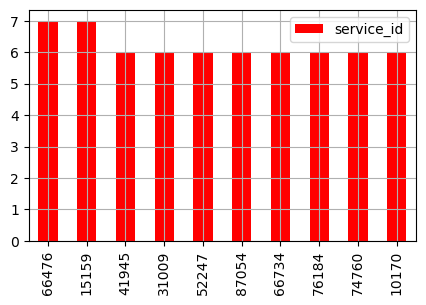

case_id
18325    43
15843    41
19178    37
13523    33
44115    30
19490    30
41233    30
34074    29
25542    29
16096    29
Name: case_id, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


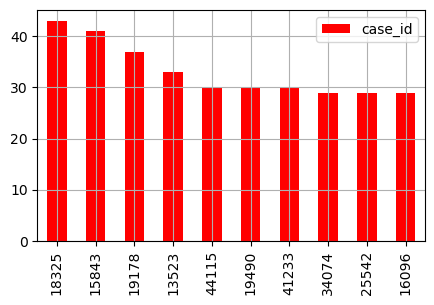

name
Общий (клинический) анализ крови развернутый (ОАК)    3780
Общий анализ мочи (ОАМ)                               1862
АЛТ                                                   1524
АСТ                                                   1504
Тиреотропный гормон (ТТГ)                             1351
Глюкоза                                               1342
УЗИ органов брюшной полости (ОБП)                     1090
Эхокардиография (Эхо-КГ)                              1039
Билирубин общий                                       1028
Креатинин                                              987
Name: name, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


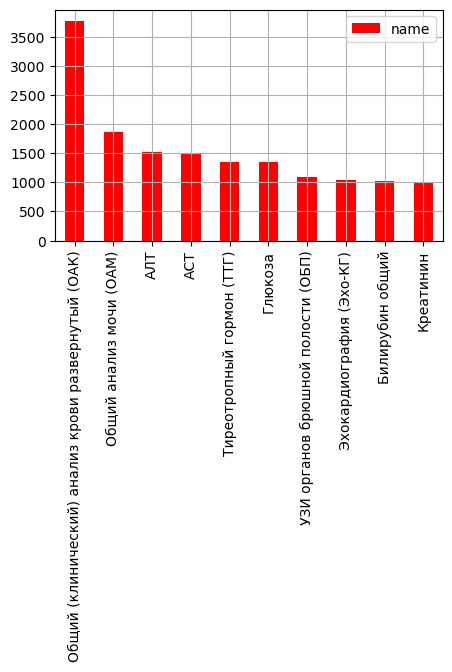

tooth_num
0     72930
47       48
46       45
37       42
16       41
28       41
17       34
27       34
36       28
18       22
Name: tooth_num, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


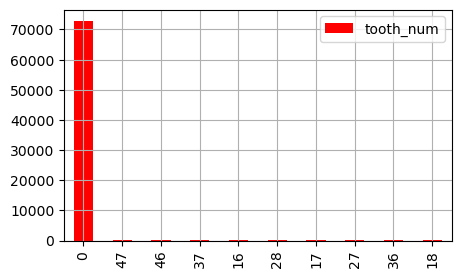

count
1     69616
5      1774
10     1004
2       689
3       292
24      118
7        85
4        63
20       58
12       33
Name: count, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


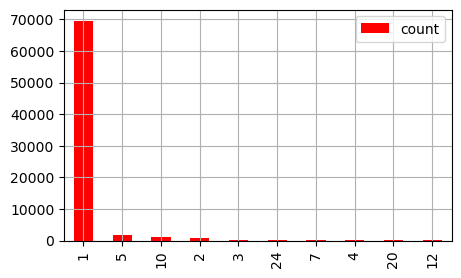

approve_result
1    53474
0    20439
Name: approve_result, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


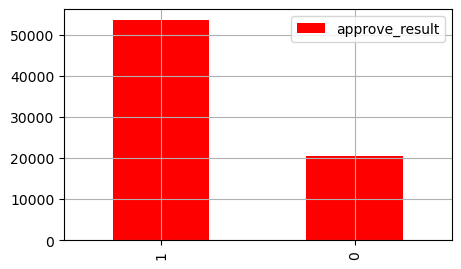

decline_reason
-                                       53474
Нет показаний                           11458
Превышение необходимого объема услуг     1978
Обратите внимание                        1662
Нет страхового случая                    1600
Нарушение этапности                      1263
Не предусмотрено ПС                      1184
Не соответствует поводу обращения         411
Не предусмотрено пс                       340
Динамическое наблюдение                   138
Name: decline_reason, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


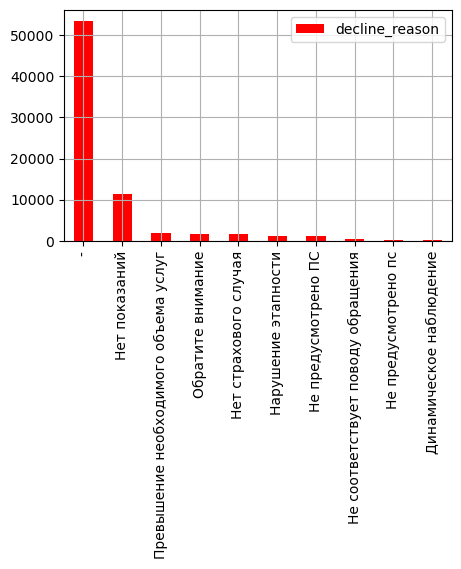

mkb
tbd                                                                                       1949
I10 Эссенциальная [первичная] гипертензия                                                  594
K02 Кариес зубов                                                                           400
J06 Острые инфекции верхних дыхательных путей множественной и неуточненной локализации     350
E03.9 Гипотиреоз неуточненный                                                              297
D50 Железодефицитная анемия                                                                271
N41.1 Хронический простатит                                                                248
N76.0 Острый вагинит                                                                       238
K02 Кариес зубов;K02.1 Кариес дентина                                                      237
J35.0 Хронический тонзиллит                                                                227
Name: mkb, dtype: int64
AxesSubplot(0.125,0.11

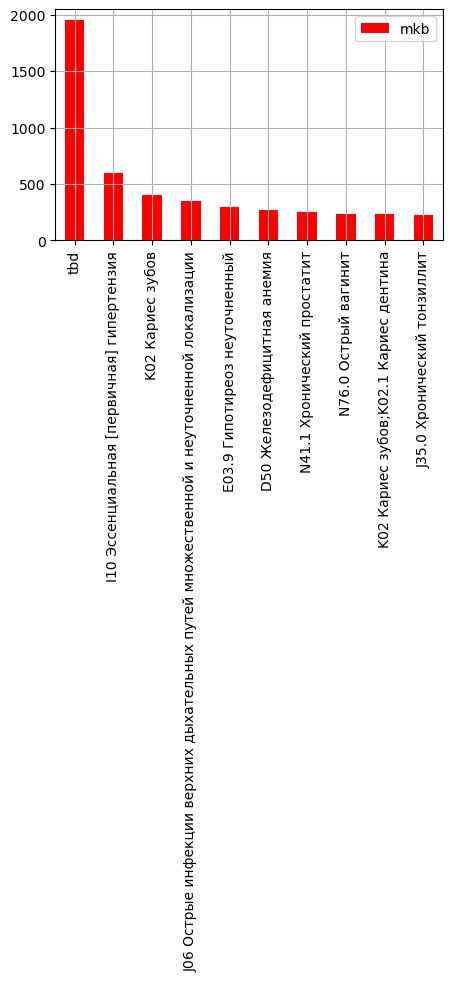

rules_worked
tbd                52619
42.28p              1466
80.30               1069
52.23p               469
80.33                412
32.05                360
37.01; 37.01.05      250
31.19                227
99.06                223
33.25                209
Name: rules_worked, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


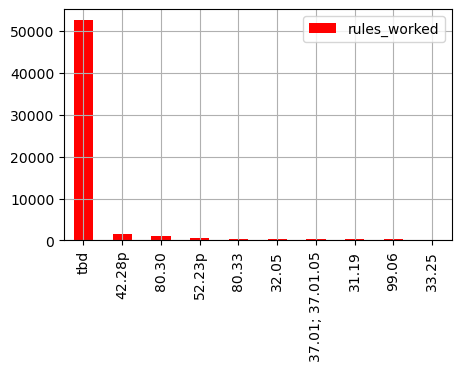

corrected
0    60852
1    13061
Name: corrected, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


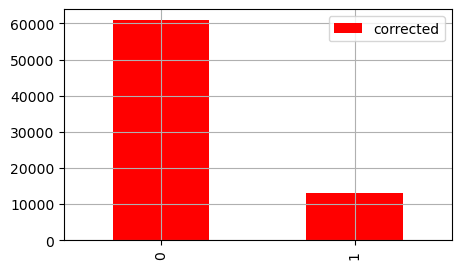

policy_number
Пр5655838    178
Пр6295145     62
Пр6825518     57
Пр6224584     52
Пр5280164     49
Пр6425547     48
Пр6945281     46
Пр7067379     45
Пр6045246     44
Пр6880462     44
Name: policy_number, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


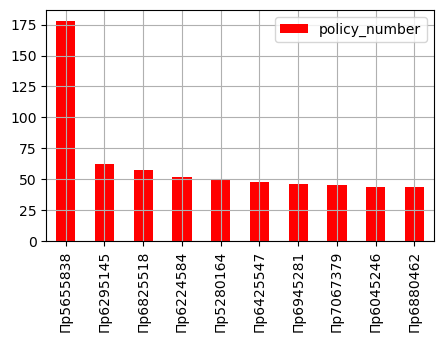

sex
0    52083
1    21830
Name: sex, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


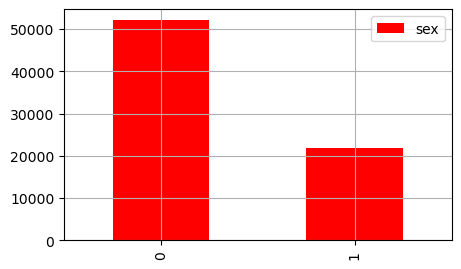

age
32    2995
34    2938
39    2935
36    2882
35    2862
33    2759
38    2705
31    2702
40    2484
37    2449
Name: age, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


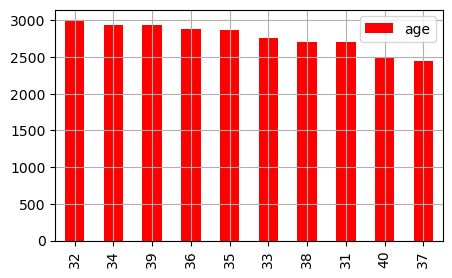

lpu_code
8      20062
87      1253
177     1088
240     1060
39       972
16       783
20       666
2        577
61       545
129      541
Name: lpu_code, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


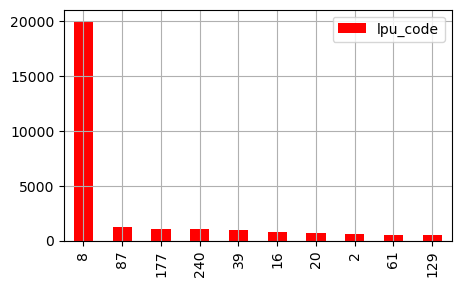

In [33]:
# список основных признаков
signs = ['service_id', 'case_id', 'name', 'tooth_num', 'count', 'approve_result',
       'decline_reason', 'mkb', 'rules_worked', 'corrected', 'policy_number',
       'sex', 'age', 'lpu_code']

# цикл для построения графиков распределения ТОП-10 значений признаков
for sign in signs:
    print(f'{sign}')
    print(df[sign].value_counts().head(10))
    print(df[sign].value_counts().head(10).plot(kind='bar', figsize=(5, 3), grid=True, color='red'))
    plt.legend()
    plt.show()

**После поверхностного знакомства с данными можно выделить:**

- "service_id" - имеют дубликаты;
- "name" - преобладают ОАК и ОАМ;
- "approve_result" - положительный результат по страховке бывает в 2,5 раза чаще;
- "decline_reason" - самая частая причина отказа - "Нет показаний";
- "mkb" - наиболее часто встречающиеся диагнозы - "Эссенциальная (первичная) гипертензия" и "Кариес зубов";
- "corrected" - корректировок в 5 раз меньше;
- "policy_number" - полис №Пр5655838 встречается более 175 раз;
- "sex" - женщин значительно больше чем мужчин;
- "age" - основной возраст застрахованных - от 32 до 40 лет;
- "lpu_code" - более 27% застрахованных обслуживаются в поликлиннике №8.

# Классификация кейсов

In [34]:
print('Соотношение корретируемых и некорректируемых значений:')
print(df['corrected'].value_counts())
print(round(df['corrected'].value_counts(normalize=True)*100, 2))

Соотношение корретируемых и некорректируемых значений:
0    60852
1    13061
Name: corrected, dtype: int64
0    82.33
1    17.67
Name: corrected, dtype: float64


## "Скорректированные" сервисы

service_id
77175    3
32268    3
95500    3
15159    3
38477    3
6142     3
53434    3
31621    3
64522    3
7091     3
Name: service_id, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


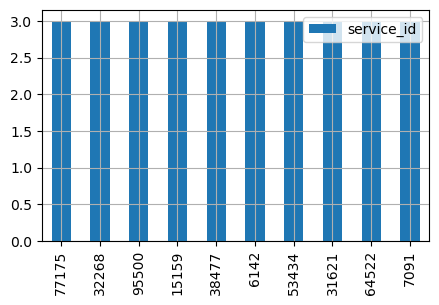

case_id
31604    26
38590    22
28123    19
18325    19
32536    17
34164    15
9982     15
16096    15
26597    14
34074    14
Name: case_id, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


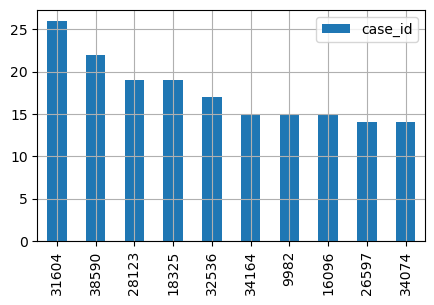

name
Общий (клинический) анализ крови развернутый (ОАК)         352
МРТ пояснично-крестцового отдела позвоночника (МРТ ПКО)    275
Глюкоза                                                    241
Общий анализ мочи (ОАМ)                                    229
МРТ головного мозга                                        218
Сеанс мануальной терапии                                   210
Классический лечебный массаж шейно-воротниковой зоны       195
АСТ                                                        186
АЛТ                                                        182
Эхокардиография (Эхо-КГ)                                   161
Name: name, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


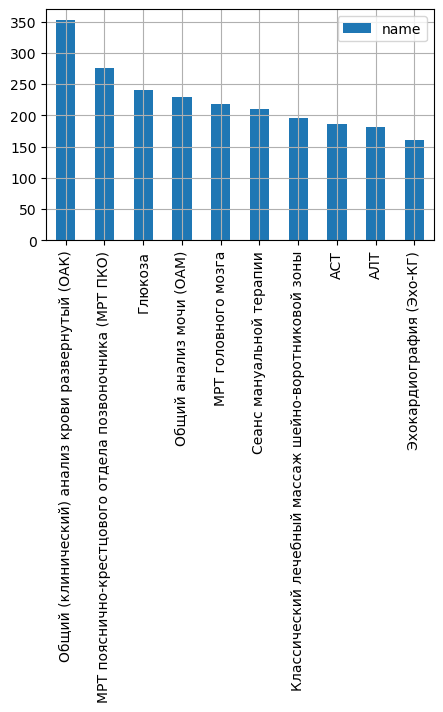

tooth_num
0     12963
18        8
38        7
28        7
16        5
25        5
47        4
37        4
15        3
48        3
Name: tooth_num, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


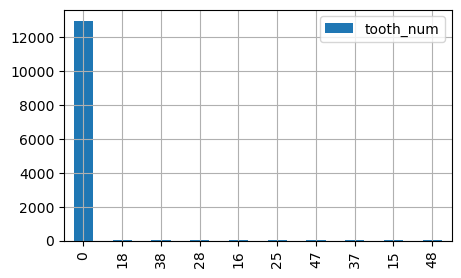

count
1     12030
5       480
10      229
3       111
2       104
7        27
4        15
20       13
24       12
6         7
Name: count, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


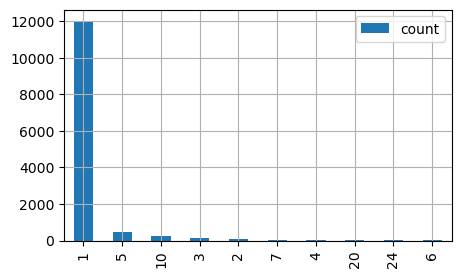

approve_result
1    6958
0    6103
Name: approve_result, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


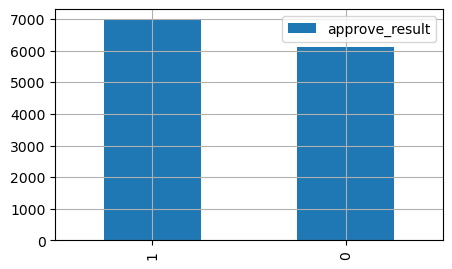

decline_reason
-                                       6958
Нет показаний                           4848
Нет страхового случая                    313
Нарушение этапности                      305
Не предусмотрено пс                      168
Динамическое наблюдение                  112
Превышение необходимого объема услуг     105
Скрининг                                  65
Без причины                               44
Обратите внимание                         43
Name: decline_reason, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


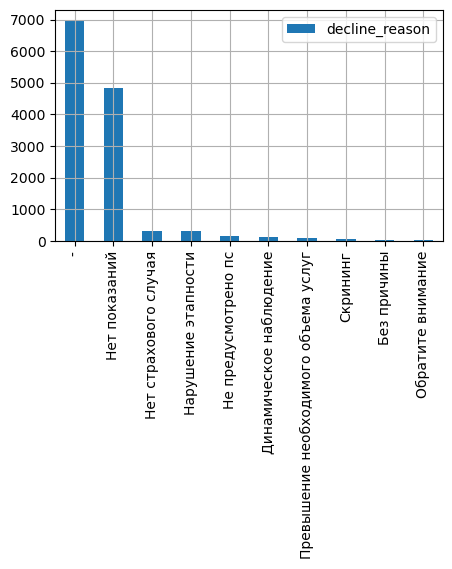

mkb
tbd                                                                     755
I10 Эссенциальная [первичная] гипертензия                                71
D50 Железодефицитная анемия                                              58
M42 Остеохондроз позвоночника                                            51
N76.0 Острый вагинит                                                     49
M53 Другие дорсопатии, не классифицированные в других рубриках           47
M54.2 Цервикалгия;M51.9 Поражение межпозвоночного диска неуточненное     45
N41.1 Хронический простатит                                              44
J35.0 Хронический тонзиллит                                              42
J30.4 Аллергический ринит неуточненный                                   42
Name: mkb, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


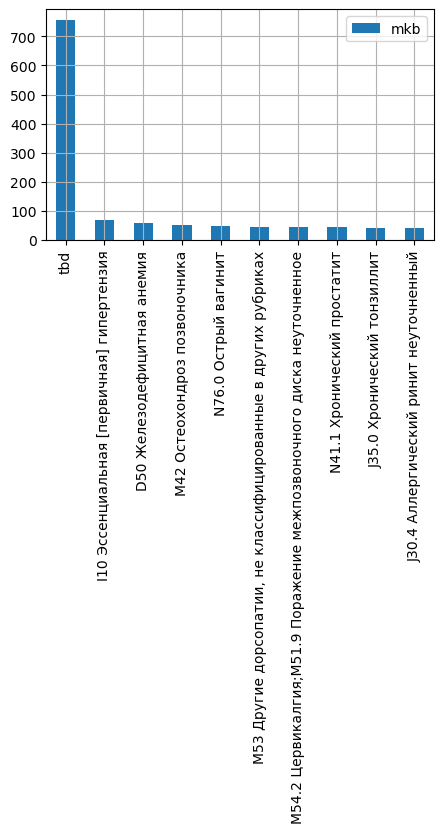

rules_worked
tbd          6103
42.28p        711
80.30         565
52.23p        238
80.33         162
99.06         121
31.19         112
52.23.01p     110
32.05          92
99.05          90
Name: rules_worked, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


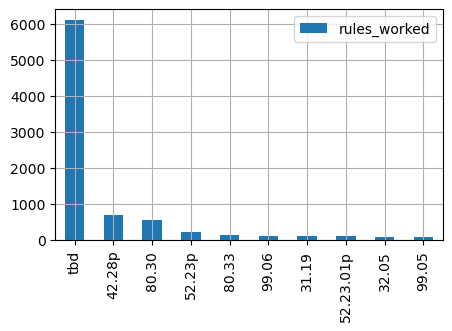

corrected
1    13061
Name: corrected, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


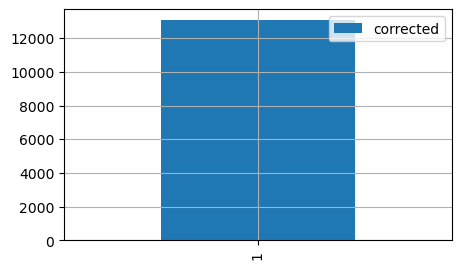

policy_number
Пр6129649        26
Пр5241087        24
Пр6425547        23
Пр7010095        22
Пр5280164        19
КСБ00336/22-1    19
Пр6507432        17
Пр6825152        17
Пр6295145        16
Пр6387226        15
Name: policy_number, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


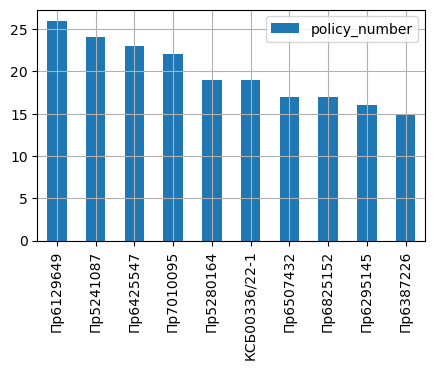

sex
0    9032
1    4029
Name: sex, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


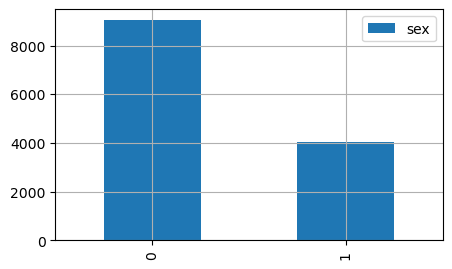

age
34    566
32    527
35    513
38    490
39    484
36    479
31    474
40    452
33    428
37    425
Name: age, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


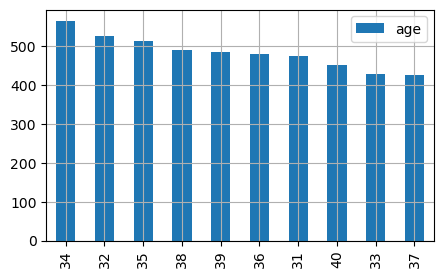

lpu_code
8      4278
87      324
240     275
177     172
352     145
39      138
16      114
129     100
81       91
278      83
Name: lpu_code, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


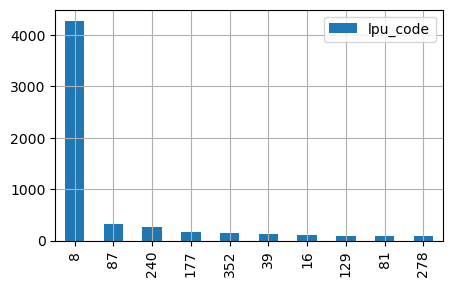

In [35]:
# датафрейм с откорректированными результатами
adjusted = df.query('corrected == 1')

# список основных признаков
signs = ['service_id', 'case_id', 'name', 'tooth_num', 'count', 'approve_result',
       'decline_reason', 'mkb', 'rules_worked', 'corrected', 'policy_number',
       'sex', 'age', 'lpu_code']

# цикл для построения графиков распределения ТОП-10 значений признаков
for sign in signs:
    print(f'{sign}')
    print(adjusted[sign].value_counts().head(10))
    print(adjusted[sign].value_counts().head(10).plot(kind='bar', figsize=(5, 3), grid=True))
    plt.legend()
    plt.show()

- Соотношение согласованных и несогласованных среди скорректированных - 6958/6103 соответственно.
- Самой частой причиной отказа в согласовании является - "Нет показаний" - 4848 случаев.
- Женщин более чем в 2 раза больше мужчин, среди скорректированных согласований застрахованных.
- Больше всего корректируют результат по поликлиннике №8 - 4278 случаев.

## Нескорректированные сервисы

service_id
41945    6
66476    6
52247    6
31205    6
45077    6
92911    5
52400    5
33514    5
66734    5
49323    5
Name: service_id, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


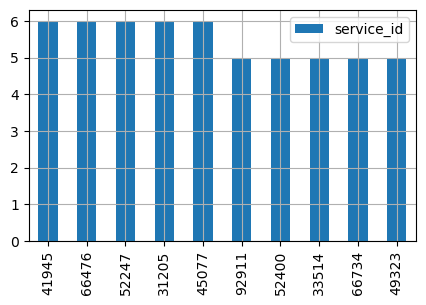

case_id
15843    41
19178    37
13523    33
19490    30
44115    30
17958    28
35787    28
16213    28
19318    28
40925    27
Name: case_id, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


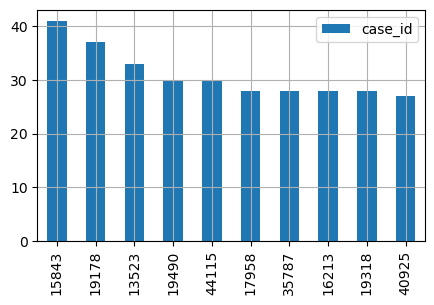

name
Общий (клинический) анализ крови развернутый (ОАК)    3428
Общий анализ мочи (ОАМ)                               1633
АЛТ                                                   1342
АСТ                                                   1318
Тиреотропный гормон (ТТГ)                             1251
Глюкоза                                               1101
УЗИ органов брюшной полости (ОБП)                      961
Билирубин общий                                        920
Эхокардиография (Эхо-КГ)                               878
Креатинин                                              831
Name: name, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


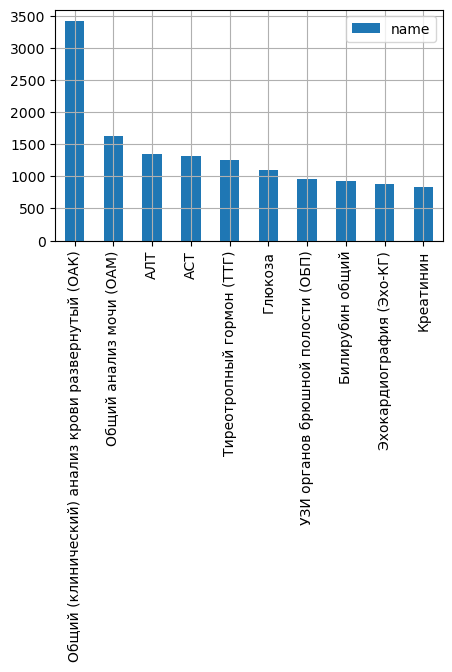

tooth_num
0     59967
47       44
46       42
37       38
16       36
28       34
17       33
27       32
36       27
26       20
Name: tooth_num, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


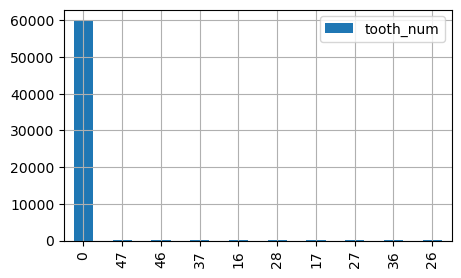

count
1     57586
5      1294
10      775
2       585
3       181
24      106
7        58
4        48
20       45
12       27
Name: count, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


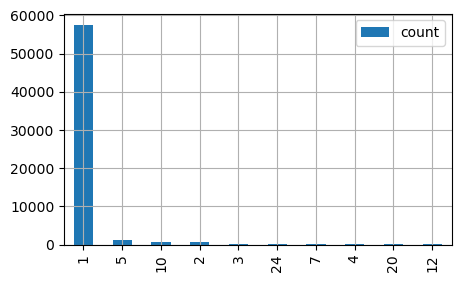

approve_result
1    46516
0    14336
Name: approve_result, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


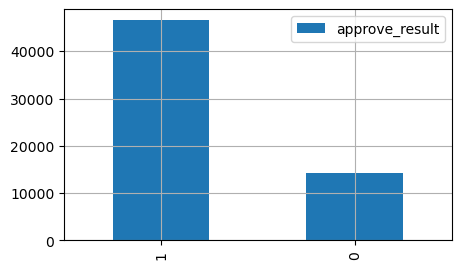

decline_reason
-                                       46516
Нет показаний                            6610
Превышение необходимого объема услуг     1873
Обратите внимание                        1619
Нет страхового случая                    1287
Не предусмотрено ПС                      1183
Нарушение этапности                       958
Не соответствует поводу обращения         388
Не предусмотрено пс                       172
Не соответствует возрасту                 114
Name: decline_reason, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


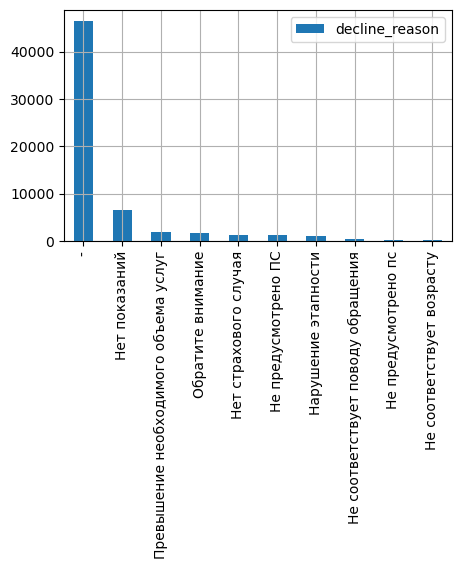

mkb
tbd                                                                                       1194
I10 Эссенциальная [первичная] гипертензия                                                  523
K02 Кариес зубов                                                                           383
J06 Острые инфекции верхних дыхательных путей множественной и неуточненной локализации     333
E03.9 Гипотиреоз неуточненный                                                              268
K02 Кариес зубов;K02.1 Кариес дентина                                                      227
D50 Железодефицитная анемия                                                                213
N41.1 Хронический простатит                                                                204
N76.0 Острый вагинит                                                                       189
J35.0 Хронический тонзиллит                                                                185
Name: mkb, dtype: int64
AxesSubplot(0.125,0.11

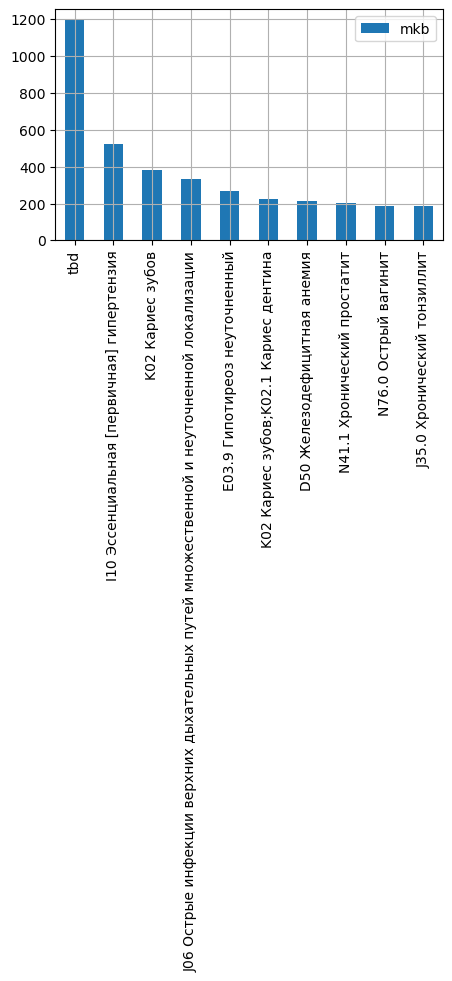

rules_worked
tbd                46516
42.28p               755
80.30                504
32.05                268
80.33                250
52.23p               231
37.01; 37.01.05      224
33.25                186
32.27; 32.48         186
30.18                160
Name: rules_worked, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


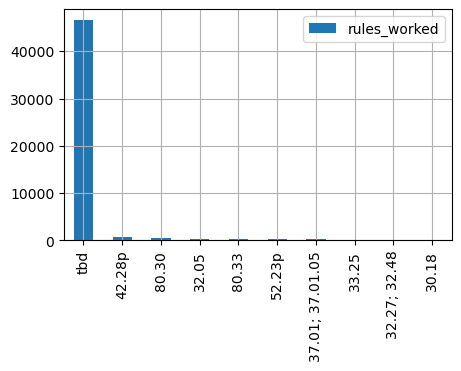

corrected
0    60852
Name: corrected, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


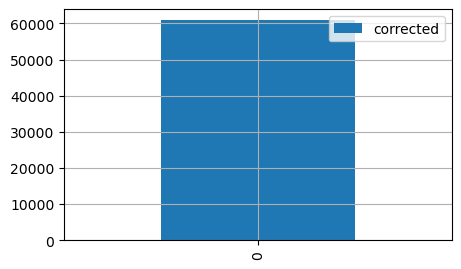

policy_number
Пр5655838    169
Пр6825518     52
Пр6295145     46
Пр6045246     44
Пр5534164     43
Пр7067379     42
Пр6224584     41
Пр6880462     40
Пр6989185     40
Пр6615642     39
Name: policy_number, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


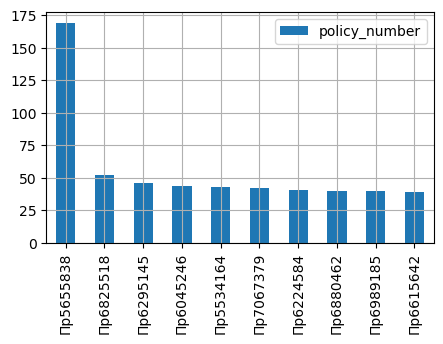

sex
0    43051
1    17801
Name: sex, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


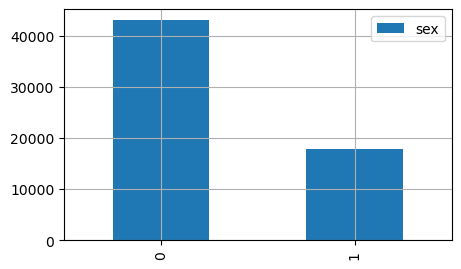

age
32    2468
39    2451
36    2403
34    2372
35    2349
33    2331
31    2228
38    2215
40    2032
37    2024
Name: age, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


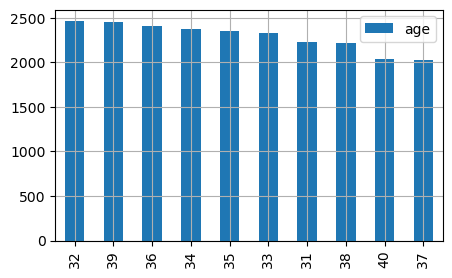

lpu_code
8      15784
87       929
177      916
39       834
240      785
16       669
20       589
2        495
61       482
156      478
Name: lpu_code, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


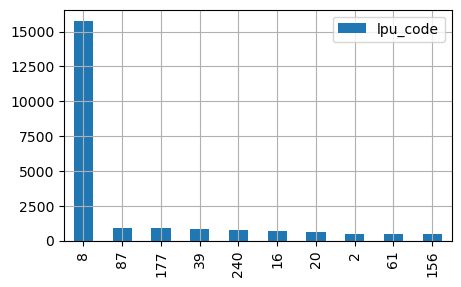

In [36]:
# датафрейм с нескорректированными сервисами
uncorrected = df.query('corrected == 0')

# список основных признаков
signs = ['service_id', 'case_id', 'name', 'tooth_num', 'count', 'approve_result',
       'decline_reason', 'mkb', 'rules_worked', 'corrected', 'policy_number',
       'sex', 'age', 'lpu_code']

# цикл для построения графиков распределения ТОП-10 значений признаков
for sign in signs:
    print(f'{sign}')
    print(uncorrected[sign].value_counts().head(10))
    print(uncorrected[sign].value_counts().head(10).plot(kind='bar', figsize=(5, 3), grid=True))
    plt.legend()
    plt.show()

- Соотношение согласованных и несогласованных среди нескорректированных сервисов - 46516/14336 соответственно.
- Самой частой причиной отказа в согласовании является - "Нет показаний" - 4848 случаев.
- Женщин более чем в 2,5 раза больше мужчин, среди некорректированных согласований застрахованных - 43051/17801 соответственно.
- Застрахованный с полисом - "Пр5655838" проходит по 169 услугам.
- Больше всего оказанных услуг в поликлиннике №8 - 15784 случаев.

## Скорректированные кейсы 

In [37]:
# выделим id скорректированных кейсов 
corrected_case = (pd.pivot_table(df, index='case_id', values='corrected', aggfunc='max').
              reset_index().query('corrected == 1').drop('corrected', axis=1)
             )

# объединим id скорректированных кейсов с общими данными
other_case = corrected_case.merge(df, on='case_id', how='left').sort_values('case_id')

other_case

,case_id,service_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
0,8194,70493,Микоплазма хоминис (Mycoplasma hominis),0,1,0,Без причины,N71.1 Хроническая воспалительная болезнь матки...,tbd,1,Пр6420782,0,30,18
1,8194,35603,Микоплазма гениталиум (Mycoplasma genitalium),0,1,0,Без причины,N71.1 Хроническая воспалительная болезнь матки...,tbd,1,Пр6420782,0,30,18
2,8194,59177,Хламидия трахоматис (Chlamydia trachomatis),0,1,0,Без причины,N71.1 Хроническая воспалительная болезнь матки...,tbd,1,Пр6420782,0,30,18
3,8194,4786,Забор материала (соскоб) на ИППП (ПЦР),0,1,0,Без причины,N71.1 Хроническая воспалительная болезнь матки...,tbd,1,Пр6420782,0,30,18
4,8194,9597,Уреаплазма уреалитикум (Ureaplasma urealyticum),0,1,0,Без причины,N71.1 Хроническая воспалительная болезнь матки...,tbd,1,Пр6420782,0,30,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28335,48180,98350,Пепсиноген 2,0,1,0,Нет показаний,K21 Гастроэзофагеальный рефлюкс;K29.5 Хроничес...,tbd,1,Пр7132502,0,22,299
28333,48180,78450,Пепсиноген 1,0,1,0,Нет показаний,K21 Гастроэзофагеальный рефлюкс;K29.5 Хроничес...,tbd,1,Пр7132502,0,22,299
28336,48199,56234,Электроэнцефалография (ЭЭГ),0,1,1,-,"G40 Эпилепсия;I64 Инсульт, не уточненный как к...",41.02.01p,1,Пр4992939,0,0,8
28337,48200,9627349,УЗИ ОМТ,0,1,0,Нет показаний,N60.1 Диффузная кистозная мастопатия,tbd,1,008ST4960000709/1,0,49,47


## Зелёные кейсы

In [38]:
# выделим id кейсов без корректировок
uncor_case = (pd.pivot_table(df, index='case_id', values='corrected', aggfunc='max').
              reset_index().query('corrected == 0').drop('corrected', axis=1)
             )

# объединим id "зелёных кейсов" с общими данными
green_case = uncor_case.merge(df, on='case_id', how='left').sort_values('case_id')

green_case

,case_id,service_id,name,tooth_num,count,approve_result,decline_reason,mkb,rules_worked,corrected,policy_number,sex,age,lpu_code
0,8193,24783,Общий IgE (иммуноглобулин E),0,1,1,-,T78.4 Аллергия неуточненная,tbd,0,Пр6061205,0,29,8
1,8195,81612,МРТ органов малого таза (ОМТ),0,1,0,Обратите внимание,D25.9 Лейомиома матки неуточненная;N83.2 Други...,8162,0,Пр5804609,0,48,8
2,8198,4142,"Прием, консультация врача-акушера-гинеколога, ...",0,1,1,-,N72 Воспалительная болезнь шейки матки;N83.2 Д...,tbd,0,Пр5286298,0,26,8
3,8198,12305,УЗИ органов малого таза (УЗИ ОМТ),0,1,1,-,N72 Воспалительная болезнь шейки матки;N83.2 Д...,tbd,0,Пр5286298,0,26,8
4,8198,41268,Мазок на онкоцитологию,0,1,1,-,N72 Воспалительная болезнь шейки матки;N83.2 Д...,tbd,0,Пр5286298,0,26,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45570,48206,87430,Общий (клинический) анализ крови развернутый (...,0,1,1,-,J06 Острые инфекции верхних дыхательных путей ...,tbd,0,Пр6949473,0,24,1904
45568,48206,76355,С-реактивный белок (СРБ),0,1,0,Нет показаний,J06 Острые инфекции верхних дыхательных путей ...,37.01.05; 37.01,0,Пр6949473,0,24,1904
45571,48207,96450,"Рентгенография пазух носа, костей носа",0,1,1,-,J01 Острый синусит,tbd,0,Пр6984059,0,30,701
45572,48209,63977,"Прием, консультация аллерголога-иммунолога, пе...",0,1,1,-,J45.8 Смешанная астма;J45.9 Астма неуточненная,tbd,0,Пр7123565,1,7,8


## Сравнительный анализ классификаций

GREEN_CASE
15843    41
19178    37
13523    33
19490    30
44115    30
35787    28
16213    28
17958    28
24001    27
40925    27
Name: case_id, dtype: int64
OTHER_CASE
18325    43
41233    30
25542    29
34074    29
16096    29
19318    29
12341    28
34073    27
13182    26
31604    26
Name: case_id, dtype: int64


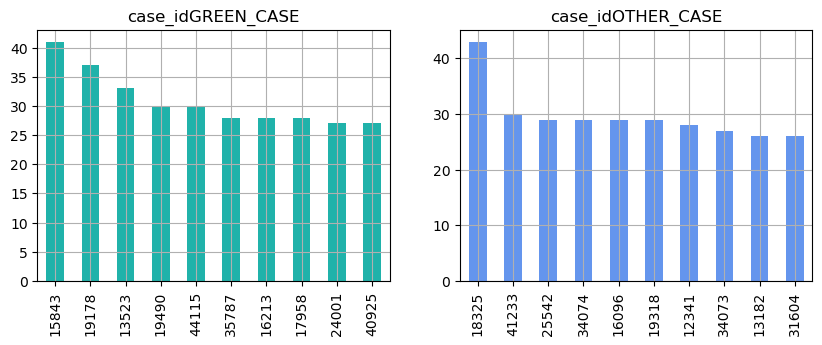

GREEN_CASE
52247    6
66734    5
33514    5
74760    5
19421    5
84885    5
49323    5
14622    5
27609    4
37398    4
Name: service_id, dtype: int64
OTHER_CASE
64717    5
60421    4
47851    4
7124     4
7928     4
23545    4
4793     4
78683    4
36795    4
79339    4
Name: service_id, dtype: int64


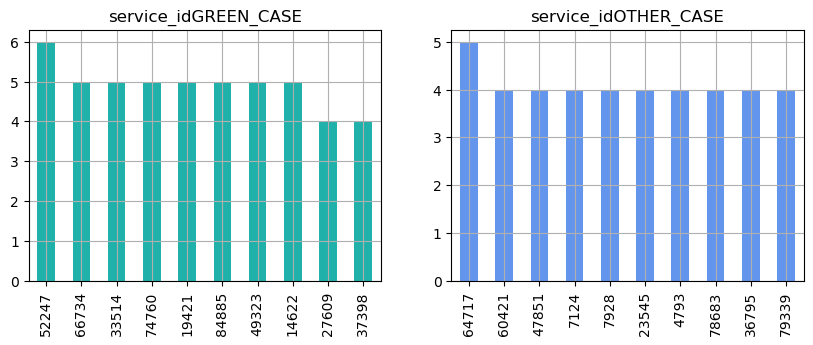

GREEN_CASE
Общий (клинический) анализ крови развернутый (ОАК)    2424
Общий анализ мочи (ОАМ)                               1149
АЛТ                                                    894
АСТ                                                    879
Тиреотропный гормон (ТТГ)                              857
Глюкоза                                                731
УЗИ органов брюшной полости (ОБП)                      720
Эхокардиография (Эхо-КГ)                               709
УЗИ органов малого таза (УЗИ ОМТ)                      665
Билирубин общий                                        620
Name: name, dtype: int64
OTHER_CASE
Общий (клинический) анализ крови развернутый (ОАК)                   1356
Общий анализ мочи (ОАМ)                                               713
АЛТ                                                                   630
АСТ                                                                   625
Глюкоза                                                            

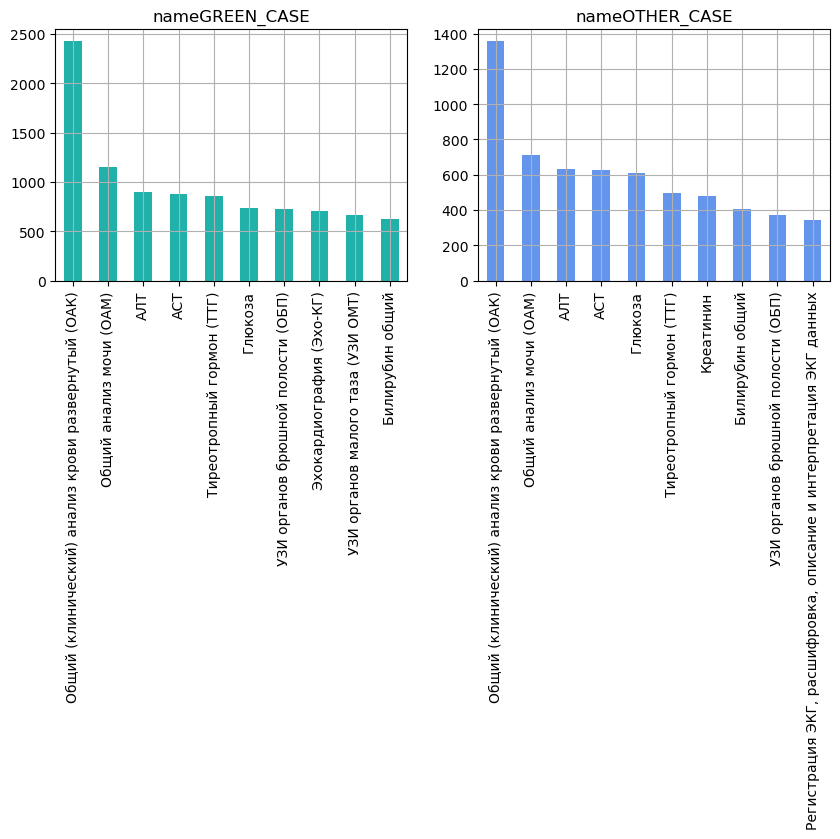

GREEN_CASE
0     44728
47       42
46       41
37       37
16       36
17       32
28       30
27       29
36       25
26       19
Name: tooth_num, dtype: int64
OTHER_CASE
0     28202
28       11
18        8
38        7
47        6
16        5
37        5
27        5
25        5
46        4
Name: tooth_num, dtype: int64


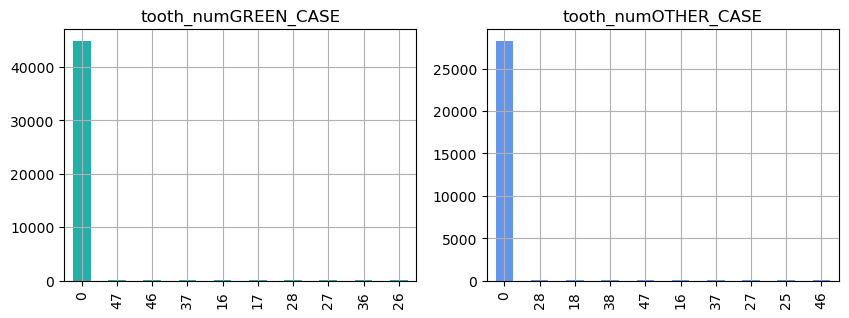

GREEN_CASE
1     42842
5      1091
10      609
2       513
3       158
24      104
7        43
4        38
20       35
12       22
Name: count, dtype: int64
OTHER_CASE
1     26774
5       683
10      395
2       176
3       134
7        42
4        25
20       23
24       14
6        12
Name: count, dtype: int64


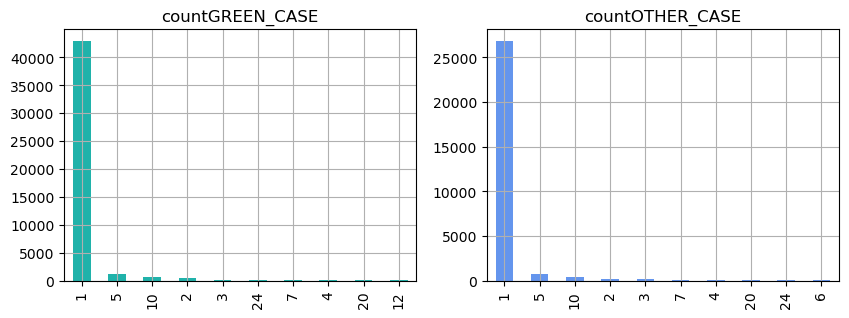

GREEN_CASE
1    35579
0     9995
Name: approve_result, dtype: int64
OTHER_CASE
1    17895
0    10444
Name: approve_result, dtype: int64


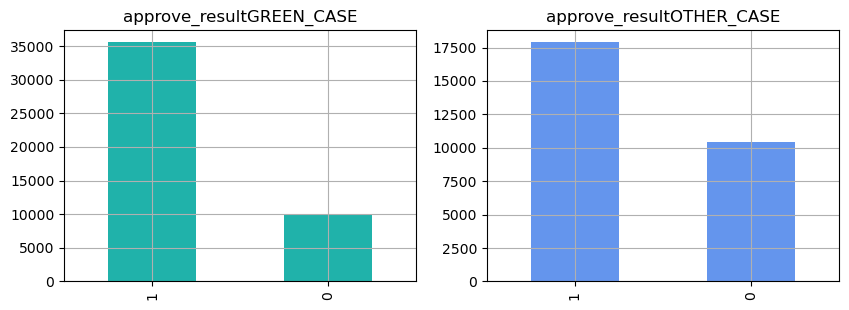

GREEN_CASE
-                                       35579
Нет показаний                            4106
Обратите внимание                        1367
Превышение необходимого объема услуг     1223
Нет страхового случая                    1091
Не предусмотрено ПС                      1068
Нарушение этапности                       605
Не соответствует поводу обращения         267
Не предусмотрено пс                        96
Не соответствует возрасту                  79
Name: decline_reason, dtype: int64
OTHER_CASE
-                                       17895
Нет показаний                            7352
Превышение необходимого объема услуг      755
Нарушение этапности                       658
Нет страхового случая                     509
Обратите внимание                         295
Не предусмотрено пс                       244
Не соответствует поводу обращения         144
Динамическое наблюдение                   122
Не предусмотрено ПС                       116
Name: decline_reason, d

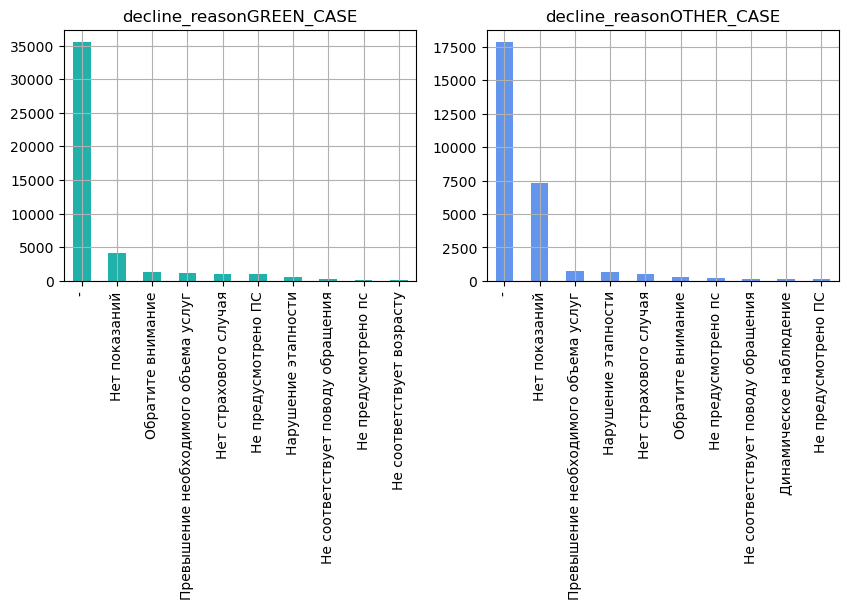

GREEN_CASE
tbd                                                                                       941
K02 Кариес зубов                                                                          374
I10 Эссенциальная [первичная] гипертензия                                                 342
J06 Острые инфекции верхних дыхательных путей множественной и неуточненной локализации    314
K02 Кариес зубов;K02.1 Кариес дентина                                                     222
E03.9 Гипотиреоз неуточненный                                                             212
N76.0 Острый вагинит                                                                      153
K86.1 Другие хронические панкреатиты                                                      152
J35.0 Хронический тонзиллит                                                               143
M42 Остеохондроз позвоночника                                                             139
Name: mkb, dtype: int64
OTHER_CASE
tbd           

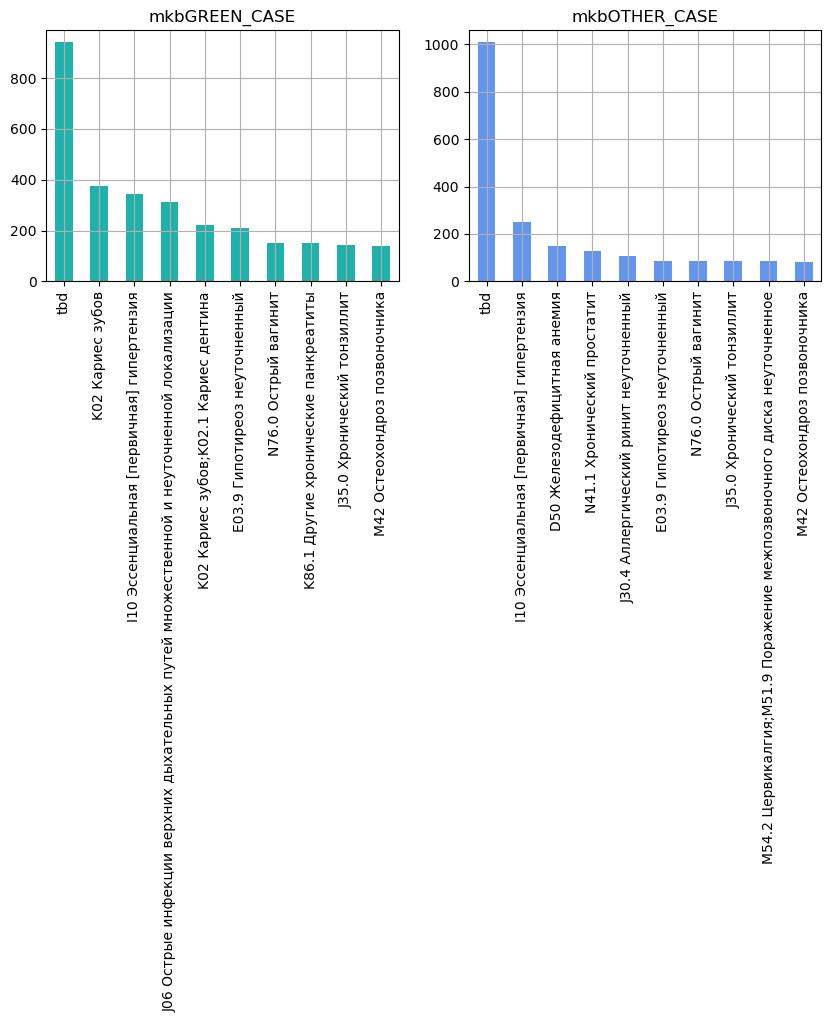

GREEN_CASE
tbd                35579
42.28p               639
80.30                413
80.33                210
52.23p               195
37.01; 37.01.05      153
32.05                152
33.25                112
32.27; 32.48         108
30.18                 96
Name: rules_worked, dtype: int64
OTHER_CASE
tbd          17040
42.28p         827
80.30          656
52.23p         274
32.05          208
80.33          202
31.19          148
99.06          145
52.23.01p      112
99.05          100
Name: rules_worked, dtype: int64


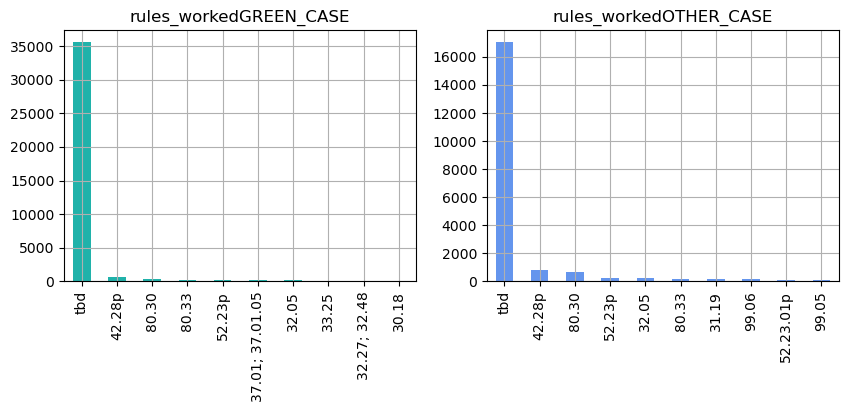

GREEN_CASE
0    45574
Name: corrected, dtype: int64
OTHER_CASE
0    15278
1    13061
Name: corrected, dtype: int64


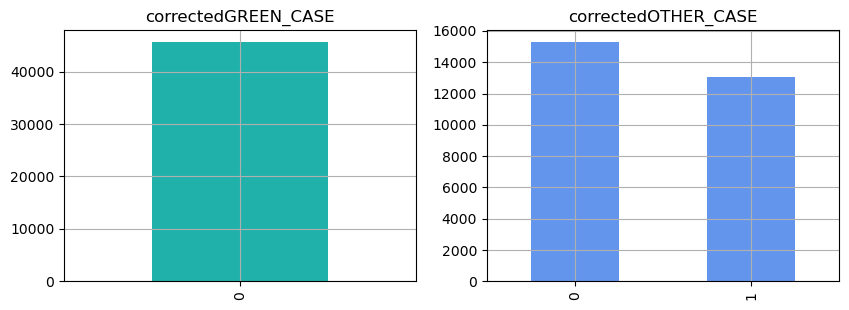

GREEN_CASE
Пр5655838    129
Пр6045246     44
Пр5534164     43
Пр6825859     38
Пр6418197     37
Пр6825518     35
Пр6296054     33
Пр6438454     33
Пр6876273     32
Пр7067379     32
Name: policy_number, dtype: int64
OTHER_CASE
Пр6295145         62
Пр5655838         49
Пр6425547         48
Пр6989185         44
Пр6845046         43
Пр5280164         43
Пр5932856         40
Пр6945281         36
НСДМС073491/22    35
Пр6818580         35
Name: policy_number, dtype: int64


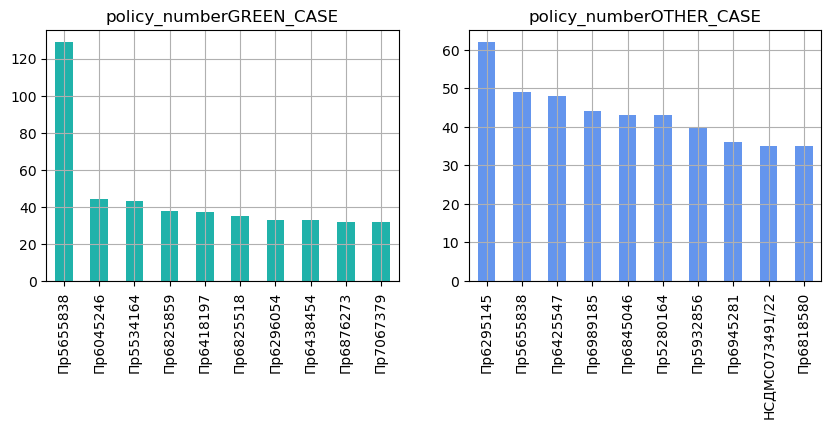

GREEN_CASE
0    32626
1    12948
Name: sex, dtype: int64
OTHER_CASE
0    19457
1     8882
Name: sex, dtype: int64


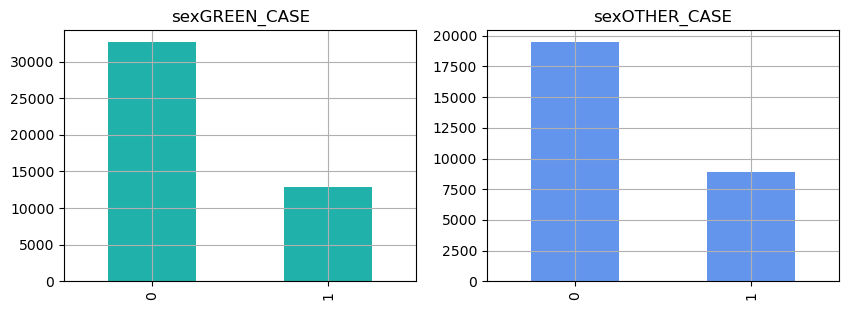

GREEN_CASE
36    1870
33    1860
39    1844
32    1823
35    1785
34    1785
38    1670
31    1658
40    1451
37    1434
Name: age, dtype: int64
OTHER_CASE
32    1172
34    1153
39    1091
35    1077
31    1044
38    1035
40    1033
37    1015
36    1012
33     899
Name: age, dtype: int64


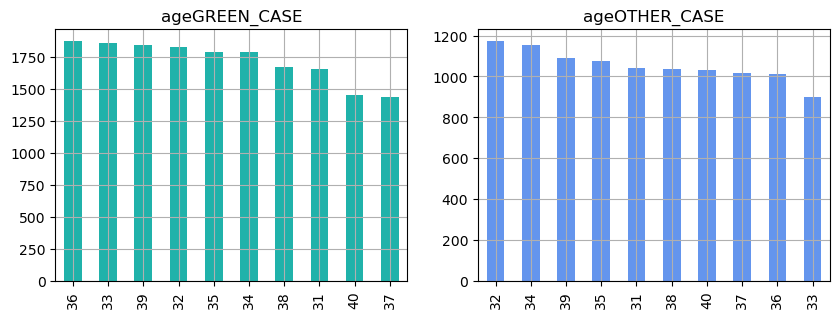

GREEN_CASE
8      11910
87       798
177      651
240      644
39       588
16       505
20       478
2        398
108      381
61       381
Name: lpu_code, dtype: int64
OTHER_CASE
8      8152
87      455
177     437
240     416
39      384
16      278
129     234
352     223
15      221
20      188
Name: lpu_code, dtype: int64


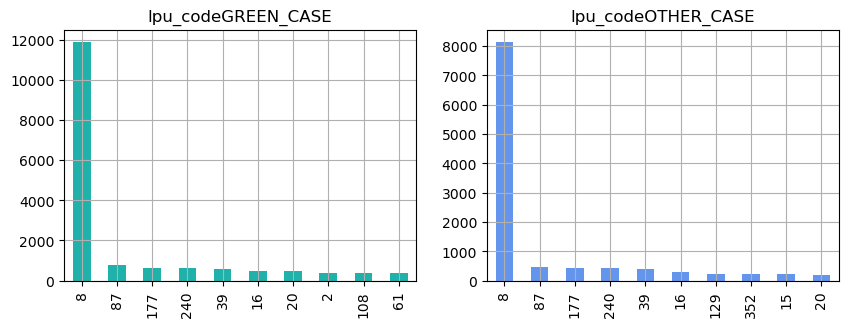

In [39]:
# список основных признаков кейсов
signs = ['case_id', 'service_id', 'name', 'tooth_num', 'count', 'approve_result', 'decline_reason',
                     'mkb', 'rules_worked', 'corrected', 'policy_number', 'sex', 'age', 'lpu_code']

# цикл для сравнительной аналитики ТОП-10 значений признаков
for sign in signs:
    print('GREEN_CASE') 
    print(green_case[sign].value_counts().head(10))
    ax1 = plt.subplot(4, 2, 1)
    ax1 = green_case[sign].value_counts().head(10).plot(kind='bar', figsize=(10, 15), grid=True, color='lightseagreen')
    ax1.set_title(f'{sign}' f'GREEN_CASE')
    
    print('OTHER_CASE')
    print(other_case[sign].value_counts().head(10))
    ax2 = plt.subplot(4, 2, 2)
    ax2 = other_case[sign].value_counts().head(10).plot(kind='bar', figsize=(10, 15), grid=True, color='cornflowerblue')
    ax2.set_title(f'{sign}' f'OTHER_CASE')
    
    plt.show()

**Выделяющиеся значения классификаций:**

- Креатинин чаще входит в услуги корректируемых кейсов;
- Доля положительных результатов у "Зелёных кейсов" 78%, у остальных 64%;
- Кариес зубов отсутствует в ТОПе корректируемых кейсов;
- В корректируемых кейсах, в 47% встречаются корректировки;
- Соотношение женщин/мужчин приблизительно одинаковое - 72% / 28% в "Зелёных кейсах" и 70% / 30% в остальных;
- Основной возраст классификаций от 31 до 40 лет;

## Алгоритм выявления "Зелёных кейсов"

**Поскольку целевой переменной является признак бинарной классификации предлагаю использовать 2 алгоритма:**
- **Логистическая регрессия;**
- **Случайный лес;**

**После обучения и валидации сравним качество моделей по метрикам Accuracy и Precision и выберем лучшую.**



### Подготовка данных для обучения модели

In [40]:
# отберём признаки для модели
df_pred = df[['case_id', 'service_id', 'count', 'corrected', 'sex', 'age', 'lpu_code']]

# разделим данные на признаки и целевую переменную
X = df_pred.drop('corrected', axis=1)
y = df_pred['corrected']

# разделим модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Логистическая регрессия

In [41]:
# зададим алгоритм на основе логистической регрессии
lr_model = LogisticRegression(solver='liblinear')

# обучим модель
lr_model.fit(X_train, y_train)

# воспользуемся обученной моделью для прогноза
predictions = lr_model.predict(X_test)
probabilities = lr_model.predict_proba(X_test)[:,1]

# оценим метрики accuracy и precision на валидационной выборке
print('Accuracy:  {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))

Accuracy:  0.83
Precision: 1.00


### Случайный лес

In [42]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0) 

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# обучим модель случайного леса
rf_model.fit(X_train_st,y_train)

# воспользуемся уже обученной моделью для прогноза
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

# оценим метрики accuracy и precision на валидационной выборке
print('Accuracy:  {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))

Accuracy:  0.82
Precision: 0.48


**Модель на основе алгоритма логистической регрессии показала себя значительно лучше по метрике Precision.**